Here I have written two funcitons Priv_POS_Laplace and Priv_POS_Gaus. Both implement the proof of stake mechanism described in our document however they add noise in different ways. The Laplace version uses Laplacian noise while the Gaus verison uses Gausian noise. The Gaussian version has the benifit that it is easier to analyze as the sum of independent Gaussian distributions is also a Gaussian distribution. This is not the case with Laplace distributions. The downside is that the Gaussian version has an aditional privacy parameter $\delta$ which needs to be calibrated.

Both mechanisms take in as input a numpy array of the current stakes of the agents. A numpy array of the change in stakes of the agents in that round (assuming that the same index applies to the same agent). A bound on how much stake can change in one transaction alpha. And a privacy paremeter epsilon < 0. The Gaussian version also takes in an additional privacy parameter $0 \leq$ delta $\leq 1$ which represents the probability of failure to protect privacy. Also note that the Gaussian Mechanism only works in the high privacy regime $0 \leq \epsilon \leq 1$

The output of both mechanisms will be a noisy stake that can then be used to elect the next leader. In order to use over multiple runs of POS do the first run with the "true" stake values and then use the noisy values from that run as inputs for other runs. Keep the privacy parameters the same across all runs.

In [ ]:
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
def Priv_POS_Laplace(stakes, change, alpha, epsilon):
    noise = np.random.laplace(0, alpha/epsilon, change.size)
    stakes = stakes + change + noise
    return stakes

def Priv_POS_Gaus(stakes, change, alpha, epsilon, delta):
    sigma = np.sqrt(2 *(alpha**2) * np.log(1.25 / delta)) * 1 / epsilon
    noise = np.random.normal(0, alpha/epsilon, change.size)
    stakes = stakes + change + noise
    return stakes

In [ ]:
def get_round_txns(rd, amount, num_participants):
    res = np.array([0.]*num_participants)
    res[rd % num_participants] = amount
    res[(rd+1) % num_participants] = -amount
    return res

In [ ]:
def predictStake(leaders,num_epochs,epoch_size):
  count = Counter(leaders)
  pred_stake = []
  for i in range(num_participants):
    pred_stake.append(count[i]*100/(num_epochs*epoch_size))

  return pred_stake

In [ ]:
#@title Laplace example
stakes = np.array([1,2,3])
change = np.array ([0.1,-0.1,0])
round1 = Priv_POS_Laplace(stakes,change,0.1,1)
round2 = Priv_POS_Laplace(round1,change,0.1,1)
round3 = Priv_POS_Laplace(round2,change,0.1,1)
print(round1)
print(round2)
print(round3)
#note that you can still kind of tell that agent 2 is losing stake and agent 1 is gaining it but with less certainty

In [ ]:
#@title Gaussian example
stakes = np.array([1,2,3])
change = np.array ([0.1,-0.1,0])
round1 = Priv_POS_Gaus(stakes,change,0.1,1,0.001)
round2 = Priv_POS_Gaus(round1,change,0.1,1,0.001)
round3 = Priv_POS_Gaus(round2,change,0.1,1,0.001)
print(round1)
print(round2)
print(round3)
#note that you can still kind of tell that agent 2 is losing stake and agent 1 is gaining it but with less certainty

In [ ]:
#@title Leader election without noise
#simulating leader election without noise
num_participants = 5
epoch_size = 1000
num_epochs = 10000
stakes = np.array([20,20,20,20,20])
nodes = np.array([i for i in range(num_participants)])
leader = []
min_epoch_stake = []
max_epoch_stake = []
pred_stake_arr = []
txns = np.zeros(shape=(epoch_size,num_participants))

for i in range(num_epochs):
    if(i%99 == 0 and i!=0):
      pred_stake = predictStake(leader,i,epoch_size)
      min_epoch_stake.append(min(pred_stake))
      max_epoch_stake.append(max(pred_stake))
      pred_stake_arr.append(pred_stake)
      
    for j in range(epoch_size):
      txns[j] = get_round_txns(j,0.1,num_participants)
      leader.append(random.choices(nodes, weights = stakes, k = 1)[0])

    txn_sum = txns.sum(axis=0)
    stakes = stakes + txn_sum

print(predictStake(leader,num_epochs,epoch_size))
print(stakes)

[20.00407, 19.99971, 20.00104, 20.01424, 19.98094]
[20. 20. 20. 20. 20.]


[0.10353535 0.04747475 0.14242424 0.0081853  0.00858586]
[0.07272727 0.0270202  0.02178932 0.1010101  0.07121212]


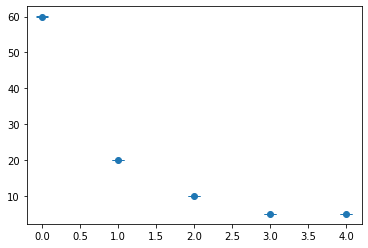

In [ ]:
#@title Error bar graph 1
pred_stake_arr = np.array(pred_stake_arr[:100])
# print(pred_stake_arr)

# make data:
np.random.seed(1)
x = [i for i in range(num_participants)]
y = stakes
yerr1 = np.amin(pred_stake_arr, axis=0)
for i in range(len(yerr1)):
  yerr1[i] = abs(stakes[i] - yerr1[i])
yerr2 = np.amax(pred_stake_arr, axis=0)
for i in range(len(yerr2)):
  yerr2[i] = abs(stakes[i] - yerr2[i])
print(yerr1)
print(yerr2)
# plot:
fig, ax = plt.subplots()

ax.errorbar(x, y, (yerr1, yerr2) , fmt='o', linewidth=2, capsize=6)

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

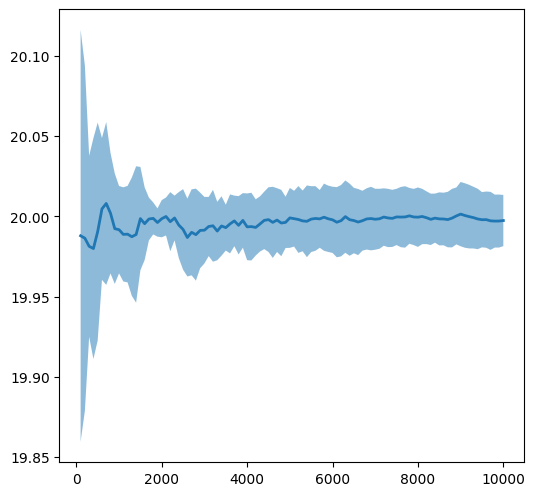

In [ ]:
#@title Change of stake graph 1
# plt.style.use('_mpl-gallery')

# make data
np.random.seed(1)
epochs = [(i+1)*100 for i in range(100)]
x = epochs
y1 = min_epoch_stake[:100]
y2 = max_epoch_stake[:100]
y = []
for i in range(len(y1)):
  y.append((y1[i]+y2[i])/2)

# plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

ax.fill_between(x, y1, y2, alpha=.5, linewidth=0)
ax.plot(x, y, linewidth=2)

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

In [ ]:
def leader_election_sim(num_participants, epoch_size, num_epochs, stakes, noisy_flag):

  leader = []
  min_epoch_stake = []
  max_epoch_stake = []
  pred_stake_arr = []
  txns = np.zeros(shape=(epoch_size,num_participants))
  nodes = np.array([i for i in range(num_participants)])
  epoch = []

  if(noisy_flag == true):
    change = np.array([0]*num_participants)
    noisy_txns = np.zeros(shape=(epoch_size,num_participants))
    eps = 5
    noisy_stake = Priv_POS_Laplace(stakes,change,0.1,eps)


  for i in range(num_epochs):
    if(noisy_flag == true):
       noisy_round_stake = noisy_stake

    if(i%99 == 0 and i!=0):
      pred_stake = predictStake(leader,i,epoch_size)
      min_epoch_stake.append(min(pred_stake))
      max_epoch_stake.append(max(pred_stake))
      pred_stake_arr.append(pred_stake)
      epoch.append(i+1)
      
    for j in range(epoch_size):
      txns[j] = get_round_txns(j,0.1,num_participants)

      if(noisy_flag == true):
        noisy_round_stake = Priv_POS_Laplace(noisy_round_stake, txns[j], 0.1, eps/2)
        leader.append(random.choices(
        nodes, 
        weights = noisy_round_stake, 
        k = 1)[0])
      else:
        leader.append(random.choices(nodes, weights = stakes, k = 1)[0])

    txn_sum = txns.sum(axis=0)
    stakes = stakes + txn_sum
    if(noisy_flag == true):
      noisy_txn_sum = Priv_POS_Laplace(txn_sum,change,0.1,eps/2)
      noisy_stake = noisy_stake + noisy_txn_sum


  if(noisy_flag == false):
    noisy_stake = stakes

  return pred_stake_arr, stakes, min_epoch_stake, max_epoch_stake, noisy_stake

In [ ]:
#simulating leader election with noise
num_participants = 5
epoch_size = 1000
num_epochs = 10000
stakes = np.array([20,20,20,20,20])
nodes = np.array([i for i in range(num_participants)])
leader = []
change = np.array([0]*num_participants)
noisy_txns = np.zeros(shape=(epoch_size,num_participants))
txns = np.zeros(shape=(epoch_size,num_participants))
eps = 5
noisy_stake = Priv_POS_Laplace(stakes,change,0.1,eps)
min_epoch_stake = []
max_epoch_stake = []
epoch = []
pred_stake_arr = []

for i in range(num_epochs):
  noisy_round_stake = noisy_stake
  if(i%99 == 0 and i!=0):
    pred_stake = predictStake(leader,i,epoch_size)
    min_epoch_stake.append(min(pred_stake))
    max_epoch_stake.append(max(pred_stake))
    epoch.append(i+1)
    pred_stake_arr.append(pred_stake)

  for j in range(epoch_size):
    txns[j] = get_round_txns(j,0.1,num_participants)
    noisy_round_stake = Priv_POS_Laplace(noisy_round_stake, txns[j], 0.1, eps/2)
    leader.append(random.choices(
        nodes, 
        weights = noisy_round_stake, 
        k = 1)[0])

  txn_sum = txns.sum(axis=0)
  stakes = stakes + txn_sum
  noisy_txn_sum = Priv_POS_Laplace(txn_sum,change,0.1,eps/2)
  noisy_stake = noisy_stake + noisy_txn_sum


print(predictStake(leader,num_epochs,epoch_size))
print(noisy_stake)

[16.84884, 20.06751, 17.50668, 21.66151, 23.91546]
[14.55953163 15.92503087 17.95525273 19.81446429 23.7285792 ]


In [ ]:
pred_stake_arr = np.array(pred_stake_arr[:100])
# print(pred_stake_arr)

# make data:
np.random.seed(1)
x = [i for i in range(num_participants)]
y = stakes
yerr1 = np.amin(pred_stake_arr, axis=0)
for i in range(len(yerr1)):
  yerr1[i] = abs(stakes[i] - yerr1[i])
yerr2 = np.amax(pred_stake_arr, axis=0)
for i in range(len(yerr2)):
  yerr2[i] = abs(stakes[i] - yerr2[i])
print(yerr1)
print(yerr2)
# plot:
fig, ax = plt.subplots(figsize=(6,6),dpi=100)

ax.errorbar(x, y, (yerr1, yerr2) , fmt='o', linewidth=2, capsize=6)

ax.set(xlim=(-0.5, 4.5), xticks=np.arange(0, 5, 1),
       ylim=(0, 65), yticks=np.arange(0, 70, 10))

ax.set_xlabel('Participants')
ax.set_ylabel('Leader Election Frequency')
ax.set_title('Leader Election Frequency for each Participant')

plt.show()

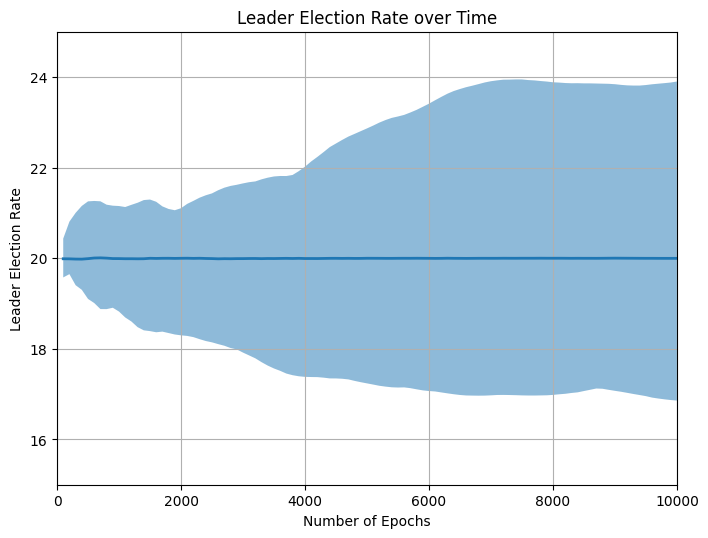

In [ ]:

# make data
np.random.seed(1)
epochs = [(i+1)*100 for i in range(100)]
x = epochs
y1 = min_epoch_stake[:100]
y2 = max_epoch_stake[:100]

# plot
# plt.figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

ax.fill_between(x, y1, y2, alpha=.5, linewidth=0)
ax.plot(x, y, linewidth=2)

# set the limits
ax.set_xlim(0, 10002)
ax.set_ylim(15, 25)

# set the grid on
ax.grid('on')

ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Leader Election Rate')
ax.set_title('Leader Election Rate over Time')


plt.show()


In [ ]:
'''
Freq attack: [60.01075, 19.99094, 10.0071, 4.9901, 5.00111]
Original Stake = [60. 20. 10.  5.  5.]
'''
freq = [60.01075, 19.99094, 10.0071, 4.9901, 5.00111]
og_stake = [60, 20, 10,  5,  5,]
x = [0,1,2,3,4]

plt.xticks([0, 1, 2, 3, 4]) 
plt.plot(x,freq, label="Freq attack")
plt.plot(x,og_stake, label="Original Stake")
plt.legend()

plt.show()

In [ ]:
'''
Original stake: [60,20,10,5,5]
Freq attack: [61.4987, 15.87465, 12.32975, 6.98395, 3.31295]
Noisy stake: [62.30671118 15.36621339 11.60095286  8.20649827 -0.0641173 ]
'''

freq = [61.4987, 15.87465, 12.32975, 6.98395, 3.31295]
og_stake = [60, 20, 10,  5,  5,]
x = [0,1,2,3,4]

plt.xticks([0, 1, 2, 3, 4]) 
plt.plot(x,freq, label="Freq attack")
plt.plot(x,og_stake, label="Original Stake")
plt.legend()

plt.show()

In [ ]:
#accidental majority


In [ ]:
acc_maj_epoch_1 = acc_maj_epoch

In [ ]:
#simulating leader election with noise

num_participants = 5
epoch_size = 1000
num_epochs = 10000
stakes = np.array([45,44,5,5,1])
true_stakes = np.array([45,44,5,5,1])
# stakes = np.array([50,30,10,5,5])
# true_stakes = np.array([50,30,10,5,5])
nodes = np.array([i for i in range(num_participants)])
leader = []
change = np.array([0]*num_participants)
noisy_txns = np.zeros(shape=(epoch_size,num_participants))
txns = np.zeros(shape=(epoch_size,num_participants))
eps = 5
noisy_stake = Priv_POS_Laplace(stakes,change,0.1,eps)
acc_maj = 0
# acc_maj_epoch_1 = []
acc_maj_epoch_2 = []

for i in range(num_epochs):
  noisy_round_stake = noisy_stake

  for j in range(epoch_size):
    txns[j] = get_round_txns(j,0.1,num_participants)
    true_stakes = noisy_round_stake + txns[j]
    noisy_round_stake = Priv_POS_Laplace(noisy_round_stake, txns[j], 0.1, eps/2)

    leader.append(random.choices(
        nodes, 
        weights = noisy_round_stake, 
        k = 1)[0])
  
    if(noisy_round_stake[1] > noisy_round_stake[0]):
      if(true_stakes[1] < true_stakes[0]):
        acc_maj += 1

  txn_sum = txns.sum(axis=0)
  stakes = stakes + txn_sum
  noisy_txn_sum = Priv_POS_Laplace(txn_sum,change,0.1,eps/2)
  noisy_stake = noisy_stake + noisy_txn_sum
  acc_maj_epoch_2.append(acc_maj/((i+1)*epoch_size))


# print(predictStake(leader,num_epochs,epoch_size))
# print(leader)
print('Prob of accidental majority: ', acc_maj/(num_epochs*epoch_size))

Prob of accidental majority:  0.0006328


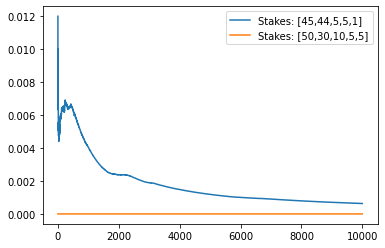

In [ ]:
x = [i+1 for i in range(num_epochs)]
y1 = acc_maj_epoch_1
y2 = acc_maj_epoch_2

plt.plot(x, y2, label="Stakes: [45,44,5,5,1]")
plt.plot(x,y1, label="Stakes: [50,30,10,5,5]")

plt.legend()

plt.show()

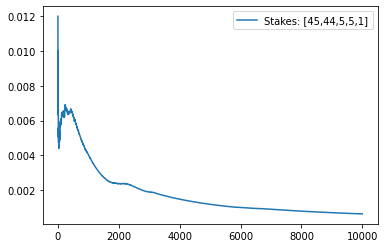

In [ ]:
x = [i+1 for i in range(num_epochs)]
y1 = acc_maj_epoch_1
y2 = acc_maj_epoch_2

plt.plot(x, y2, label="Stakes: [45,44,5,5,1]")
plt.legend()

plt.show()

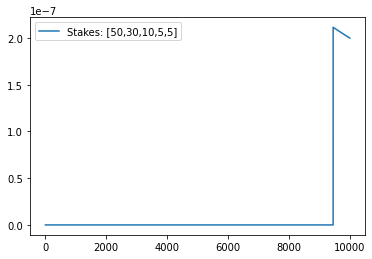

In [ ]:
x = [i+1 for i in range(num_epochs)]
y1 = acc_maj_epoch_1
y2 = acc_maj_epoch_2

plt.plot(x,y1, label="Stakes: [50,30,10,5,5]")
plt.legend()

plt.show()

In [ ]:
max(y1)

2.1155066638459911e-07

In [ ]:
max(y2)

0.012

In [ ]:
#Analysis of noisy stake of [45,44,5,5,1]:
print(np.abs(noisy_stake))
print(stakes)

[5.36364345e+01 3.94675353e+01 4.97835251e-02 4.06877022e+00
 1.11794174e+01]
[45. 44.  5.  5.  1.]
